In [1]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex3.hodgkin_huxley import HH
from neurodynex3.tools import input_factory

ld: warning: -pie being ignored. It is only used when linking a main executable
ld: unsupported tapi file type '!tapi-tbd' in YAML file '/Library/Developer/CommandLineTools/SDKs/MacOSX10.15.sdk/usr/lib/libSystem.tbd' for architecture x86_64
clang-10: error: linker command failed with exit code 1 (use -v to see invocation)
WARNING    Cannot use Cython, a test compilation failed: command '/Users/ozdil/anaconda3/envs/bmnn/bin/x86_64-apple-darwin13.4.0-clang++' failed with exit code 1 (LinkError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


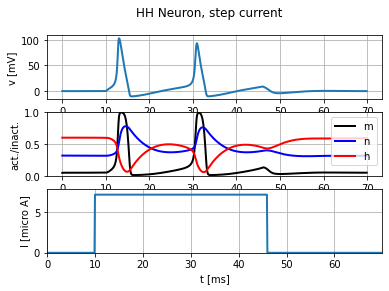

In [2]:
%matplotlib inline

HH.getting_started()

# 5.1. Exercise: step current response

We study the response of a Hodgkin-Huxley neuron to different input currents. Have a look at the documentation of the functions HH.simulate_HH_neuron() and HH.plot_data() and the module neurodynex3.tools.input_factory.

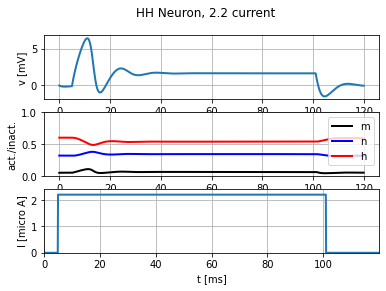

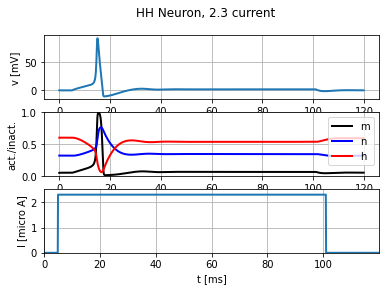

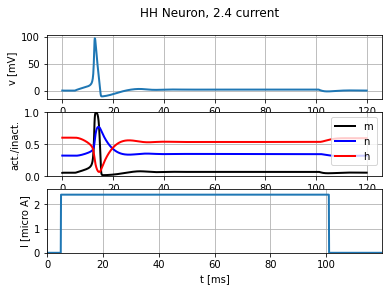

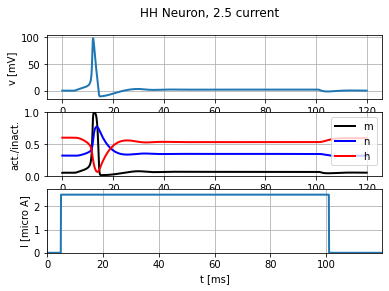

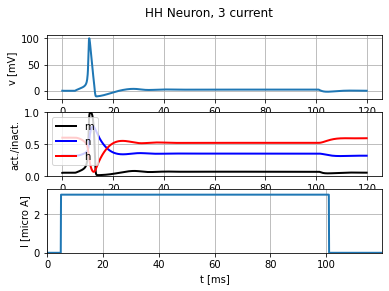

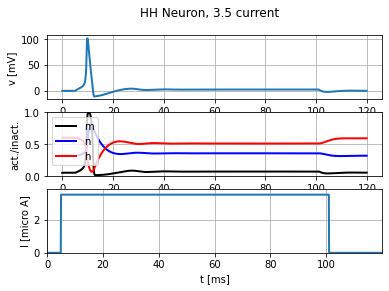

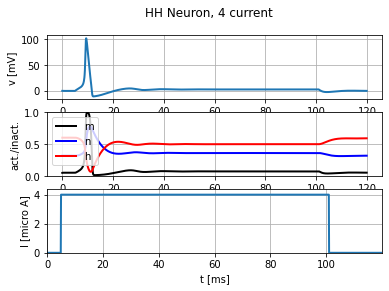

In [3]:
%matplotlib inline
# Find the minimum lowest step current to generate spike: 2.3 nA
I_min = [2.2, 2.3, 2.4, 2.5, 3, 3.5, 4]
for i_min in I_min:
    current = input_factory.get_step_current(5, 100, b2.ms, i_min *b2.uA)
    state_monitor = HH.simulate_HH_neuron(current, 120 * b2.ms)
    HH.plot_data(state_monitor, title=f"HH Neuron, {i_min} current")

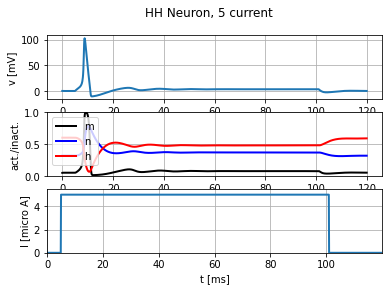

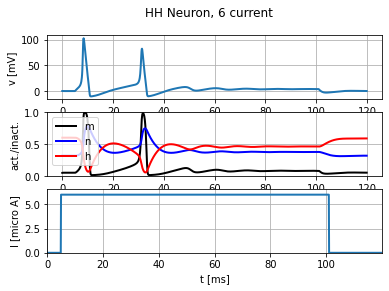

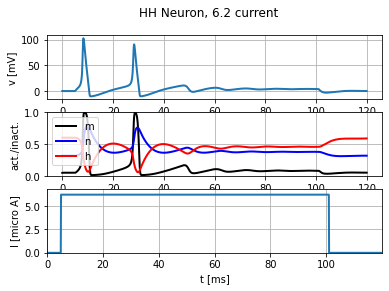

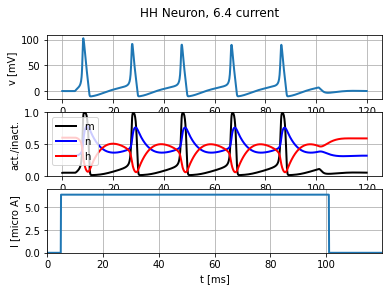

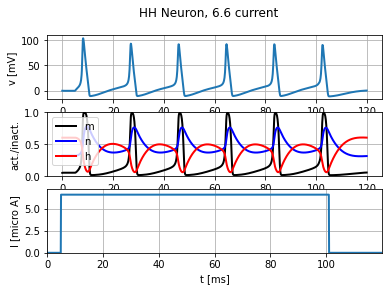

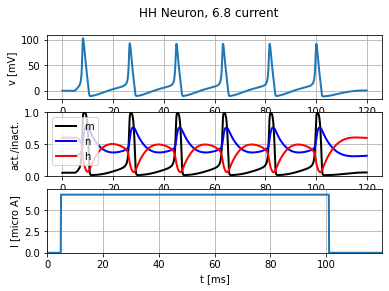

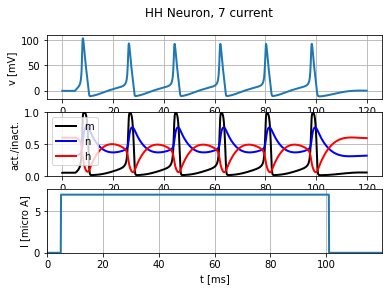

In [4]:
%matplotlib inline
# Find the minimum lowest step current to generate repetitive firing: 6.6 nA
I_min = [5, 6,6.2, 6.4, 6.6, 6.8, 7]
for i_min in I_min:
    current = input_factory.get_step_current(5, 100, b2.ms, i_min *b2.uA)
    state_monitor = HH.simulate_HH_neuron(current, 120 * b2.ms)
    HH.plot_data(state_monitor, title=f"HH Neuron, {i_min} current")

# 5.2. Exercise: slow and fast ramp current

The minimal current to elicit a spike does not just depend on the amplitude 𝐼
or on the total charge 𝑄 of the current, but on the “shape” of the current. Let’s see why:

Inject a slow ramp current into a HH neuron. The current has amplitude 0A at t in [0, 5] ms and linearly increases to an amplitude of 12.0uAmp at t=ramp_t_end. At t>ramp_t_end, the current is set to 0A. Using the following code, reduce slow_ramp_t_end to the maximal duration of the ramp current, such that the neuron does not spike. Make sure you simulate system for at least 20ms after the current stops.

voltage_slow=0.008783060418687283


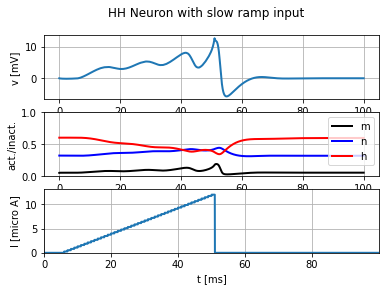

In [88]:
%matplotlib inline 

b2.defaultclock.dt = 0.02*b2.ms
slow_ramp_t_end = 50

slow_ramp_current = input_factory.get_ramp_current(5, slow_ramp_t_end, b2.ms, 0.*b2.uA, 12.0*b2.uA)
state_monitor = HH.simulate_HH_neuron(slow_ramp_current, 100 * b2.ms)
idx_t_end = int(round(slow_ramp_t_end*b2.ms / b2.defaultclock.dt))
voltage_slow = state_monitor.vm[0,idx_t_end]
print("voltage_slow={}".format(voltage_slow))

HH.plot_data(state_monitor, title="HH Neuron with slow ramp input")

Here the Na+ channels are able to partially close and open but what happens is that K+ channels open after a certain current input, which leads to suddent discharge of the K+ ions from the inside of the cell to the outside. 

voltage_fast=0.005881880724047649


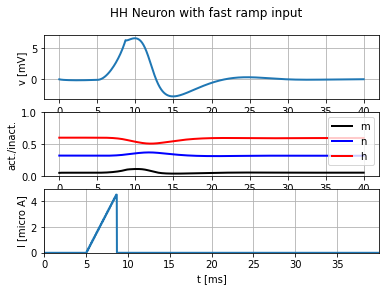

In [6]:
%matplotlib inline 

# Same with fast ramp
b2.defaultclock.dt = 0.02*b2.ms
fast_ramp_t_end = 86

fast_ramp_current = input_factory.get_ramp_current(50, fast_ramp_t_end, 0.1*b2.ms, 0.*b2.uA, 4.5*b2.uA)
state_monitor = HH.simulate_HH_neuron(fast_ramp_current, 40 * b2.ms)
idx_t_end = int(round(fast_ramp_t_end*0.1*b2.ms / b2.defaultclock.dt))
voltage_fast = state_monitor.vm[0,idx_t_end]
print("voltage_fast={}".format(voltage_fast))

HH.plot_data(state_monitor, title="HH Neuron with fast ramp input")

When a very fast ramp occurs, the Na channel (faster one) cannot keep up with the increase. However, when the input is long enough, then Na+ channel (m) can get high enough to initate a spike. 

# 5.3. Exercise: Rebound Spike

A HH neuron can spike not only if it receives a sufficiently strong depolarizing input current but also after a hyperpolarizing current. Such a spike is called a rebound spike.

If the change in the input current is big enough then the spike occurs.

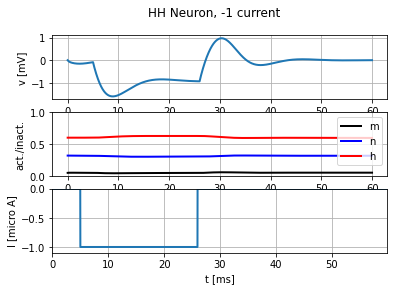

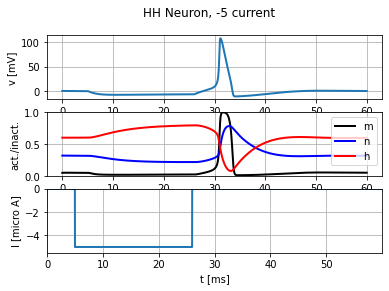

In [7]:
%matplotlib inline 

I_min = [-1, -5]
for i_min in I_min:
    current = input_factory.get_step_current(5, 25, b2.ms, i_min *b2.uA)
    state_monitor = HH.simulate_HH_neuron(current, 60 * b2.ms)
    HH.plot_data(state_monitor, title=f"HH Neuron, {i_min} current")
    
# Membrane potential drops when we inject a negative current, as a result of which channels open

# 5.4. Exercise: Brian implementation of a HH neuron

In the source code of your function, change the density of sodium channels. Increase it by a factor of 1.4. Stimulate this modified neuron with a step current.

    What is the minimal current leading to repetitive spiking? Explain.
    Run a simulation with no input current to determine the resting potential of the neuron. Link your observation to the Goldman–Hodgkin–Katz voltage equation.
    If you increase the sodium conductance further, you can observe repetitive firing even in the absence of input, why?


In [8]:
def simulate_hodgkin_huxley(input_current, scale, simulation_time):

    """A Hodgkin-Huxley neuron implemented in Brian2.

    Args:
        input_current (TimedArray): Input current injected into the HH neuron
        simulation_time (float): Simulation time [seconds]

    Returns:
        StateMonitor: Brian2 StateMonitor with recorded fields
        ["vm", "I_e", "m", "n", "h"]
    """

    # neuron parameters
    El = 10.6 * b2.mV 
    EK = -12 * b2.mV 
    ENa = 115 * b2.mV 
    gl = 0.3 * b2.msiemens
    gK = 36 * b2.msiemens 
    gNa = 120 * b2.msiemens * scale
    C = 1 * b2.ufarad

    # forming HH model with differential equations
    eqs = """
    I_e = input_current(t,i) : amp
    membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
        gl*(El-vm) + gK*n**4*(EK-vm) : amp
    alphah = .07*exp(-.05*vm/mV)/ms    : Hz
    alpham = .1*(25*mV-vm)/(exp(2.5-.1*vm/mV)-1)/mV/ms : Hz
    alphan = .01*(10*mV-vm)/(exp(1-.1*vm/mV)-1)/mV/ms : Hz
    betah = 1./(1+exp(3.-.1*vm/mV))/ms : Hz
    betam = 4*exp(-.0556*vm/mV)/ms : Hz
    betan = .125*exp(-.0125*vm/mV)/ms : Hz
    dh/dt = alphah*(1-h)-betah*h : 1
    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dvm/dt = membrane_Im/C : volt
    """

    neuron = b2.NeuronGroup(1, eqs, method="exponential_euler")

    # parameter initialization
    neuron.vm = 0
    neuron.m = 0.05
    neuron.h = 0.60
    neuron.n = 0.32

    # tracking parameters
    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "m", "n", "h"], record=True)

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon

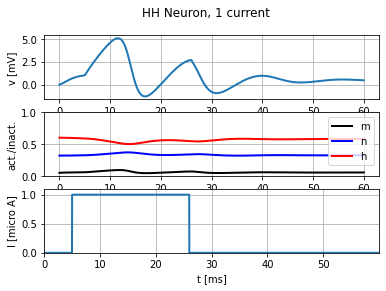

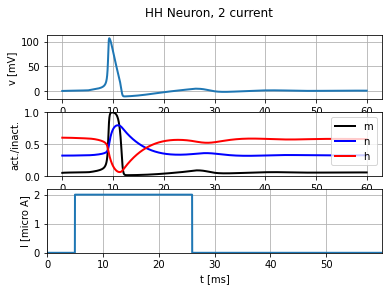

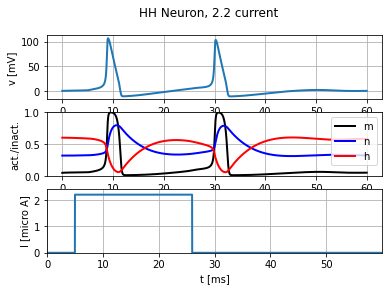

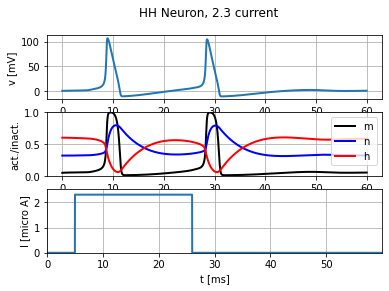

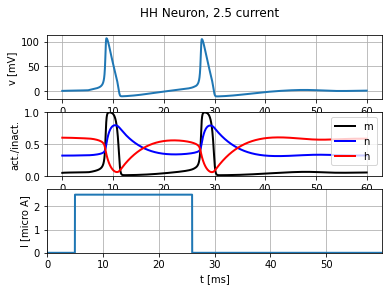

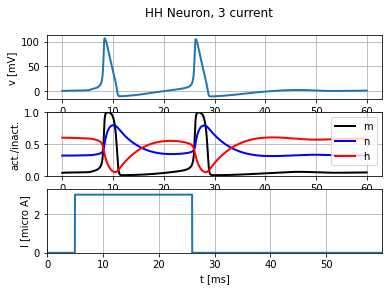

In [74]:
%matplotlib inline 

# Find the minimum lowest step current to generate repetitive spike: 9 uA, higher then the original example
# When we increase the conductance of Na channels, they let more Na+ ions flow into the cell.
# Therefore, they have a bigger impact on the membrane potential. 
I_min = [1,2,2.2,2.3,2.5,3]
for i_min in I_min:
    current = input_factory.get_step_current(5, 25, b2.ms, i_min *b2.uA)
    state_monitor = simulate_hodgkin_huxley(current, 1.4, 60 * b2.ms)
    HH.plot_data(state_monitor, title=f"HH Neuron, {i_min} current")


WARNING    /Users/ozdil/anaconda3/envs/bmnn/lib/python3.9/site-packages/neurodynex3/hodgkin_huxley/HH.py:61: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.axis((
 [py.warnings]


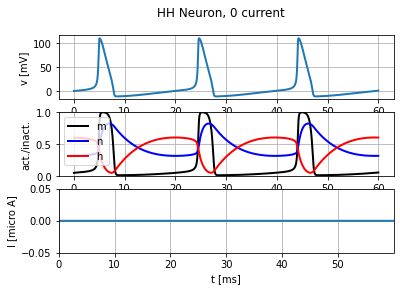

In [79]:
%matplotlib inline 

i_min = 0
na_scale = 2
current = input_factory.get_step_current(5, 25, b2.ms, i_min *b2.uA)
state_monitor = simulate_hodgkin_huxley(current, na_scale, 60 * b2.ms)
HH.plot_data(state_monitor, title=f"HH Neuron, {i_min} current")


WARNING    /Users/ozdil/anaconda3/envs/bmnn/lib/python3.9/site-packages/neurodynex3/hodgkin_huxley/HH.py:61: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.axis((
 [py.warnings]


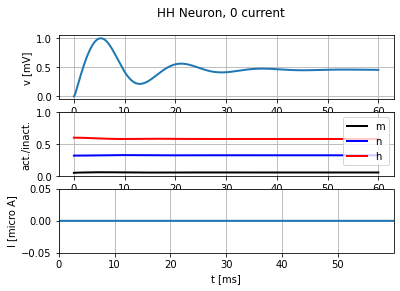

In [80]:
%matplotlib inline 

current = input_factory.get_step_current(5, 25, b2.ms, 0 *b2.uA)
state_monitor = simulate_hodgkin_huxley(current, 1.4, 60 * b2.ms)
HH.plot_data(state_monitor, title=f"HH Neuron, {i_min} current")
 
# Here the membrane potential goes towards the reversal potential of Na 